##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Face Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect face landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 10.2 MB/s eta 0:00:00


Then download the off-the-shelf model bundle(s). Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker#models) for more information about these model bundles.

In [2]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

## Visualization utilities

In [3]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

In [ ]:
!wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.png")
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [4]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
  content = uploaded[filename]
  with open(filename, 'wb') as f:
    f.write(content)

if len(uploaded.keys()):
  IMAGE_FILE = next(iter(uploaded))
  print('Uploaded file:', IMAGE_FILE)



import cv2
# Use OpenCV’s VideoCapture to load the input video.
cap = cv2.VideoCapture("Video_test.mp4")

# Load the frame rate of the video using OpenCV’s CV_CAP_PROP_FPS
# You’ll need it to calculate the timestamp for each frame.
fps = cap.get(cv2.CAP_PROP_FPS)

Saving Video_test.mp4 to Video_test.mp4
Uploaded file: Video_test.mp4


Video fps: 906.0
Frame loaded successfully!


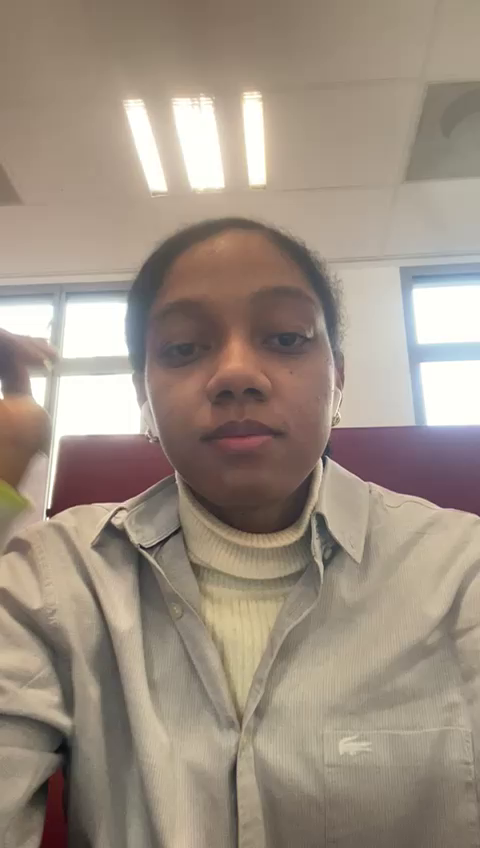

In [20]:
import cv2
from google.colab.patches import cv2_imshow
# Use OpenCV’s VideoCapture to load the input video.
cap = cv2.VideoCapture("Video_test.mp4")

# Load the frame rate of the video using OpenCV’s CV_CAP_PROP_FPS
# You’ll need it to calculate the timestamp for each frame.
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)

fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
print("Video fps:", total_frame)

if not cap.isOpened():
    print("Error: Cannot open video file.")
    exit()

success, frame = cap.read()
if success:
    print("Frame loaded successfully!")
    cv2_imshow( frame)
    cv2.waitKey(0)  # Wait for a key press
else:
    print("Error: Could not read first frame.")

cap.release()
cv2.destroyAllWindows()

## Running inference and visualizing the results

Here are the steps to run face landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker/python) to learn more about configuration options that this task supports.


In [22]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
VisionRunningMode = mp.tasks.vision.RunningMode
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task') #to update
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       running_mode=VisionRunningMode.VIDEO,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1) #to update

detector = vision.FaceLandmarker.create_from_options(options)


# STEP 3: Load the input image.            update to video
#image = mp.Image.create_from_file("image.png")
# Convert the frame received from OpenCV to a MediaPipe’s Image object.########
# Loop through each frame in the video using VideoCapture#read()
frame_idx = 0
while cap.isOpened():
  success, frame = cap.read()
  if not success:
    print("No images in the frame")
    break
    # Convertir BGR (OpenCV) en RGB (MediaPipe)
  rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)


# STEP 4: Detect face landmarks from the input image.   update to video
#detection_result = detector.detect(image)
# For video
  timestamp_ms = int((frame_idx*1000)/fps)
  detection_result = detector.detect_for_video(image, timestamp_ms)
  frame_idx += 1


# STEP 5: Process the detection result. In this case, visualize it.
  annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
  cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

We will also visualize the face blendshapes categories using a bar graph.

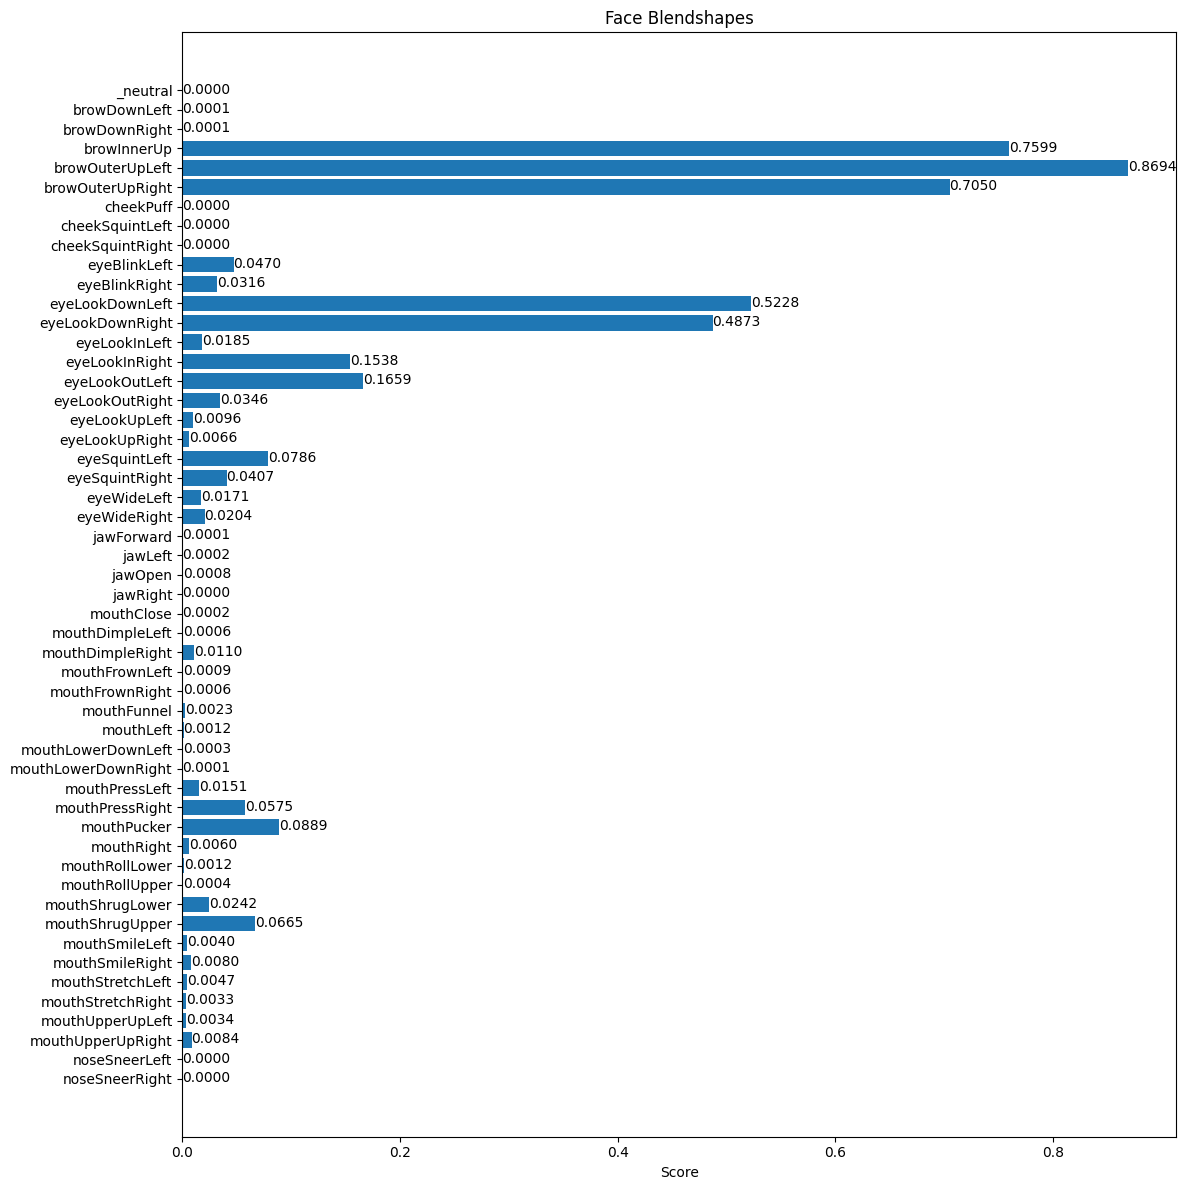

In [23]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

And print the transformation matrix.

In [24]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.95385706e-01, -9.39346403e-02, -1.95967164e-02,
        -1.15738761e+00],
       [ 9.43908989e-02,  9.95250404e-01,  2.38240007e-02,
         1.10808933e+00],
       [ 1.72657352e-02, -2.55637243e-02,  9.99524355e-01,
        -6.00730858e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]
